In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import llops as yp
import math

# get an error with this import for some reason.
import ndoperators as ops
from libwallerlab.utilities import display, io, simulation, transformation
import libwallerlab.optics.ledarray as ledarray
import libwallerlab.optics.pupil as pupilgen

# Optimization algorithms
from ndoperators.solvers import objectivefunctions, regularizers

# Set backend
yp.config.setDefaultBackend('arrayfire')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Object

In [3]:
object_true = simulation.ucb(shape=(128,128))
object_size = yp.shape(object_true)

## Define Settings

In [4]:
# Camera Parameters
camera_pixel_size = 6.5

# Illumination parameters
illumination_device_name = 'quasi-dome'
illumination_wavelength = .53  #um
illumination_na = 0.8

# Objective Parameters
objective_na = .25
objective_mag = 10    #objective mag

# System Parameters
system_mag = 2

# Derived constants
upsampling_factor = math.ceil(illumination_na / objective_na)
pixel_size_measurement = camera_pixel_size / objective_mag
pixel_size_object = pixel_size_measurement / upsampling_factor
dky, dkx = [1 / (sz * pixel_size_object) for sz in object_size]
measurement_size = tuple([int(sz / upsampling_factor) for sz in object_size])

## Generate LED Positions and Pupil Function

In [5]:
# Generate LED Positions
led_position_list_full = ledarray.getPositionsNa(illumination_device_name)
led_board_indicies_full = ledarray.getBoardIndicies(illumination_device_name)
led_position_list = [src for src in led_position_list_full if np.sqrt(src[0] ** 2 + src[1] ** 2) <= illumination_na]
led_board_indicies = [board_index for board_index, src in zip(led_board_indicies_full, led_position_list_full) if np.sqrt(src[0] ** 2 + src[1] ** 2) <= illumination_na]

# Generate Pupil
p = yp.asarray(pupilgen.pupil(measurement_size, pixel_size_measurement, illumination_wavelength, objective_na))

## Apply Distortion to Each Board (Except Center Board)

<IPython.core.display.Javascript object>


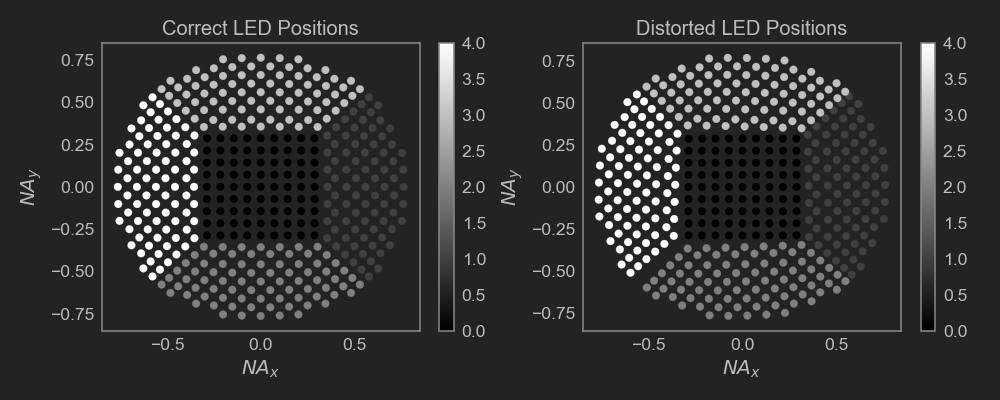

In [27]:
# Get list of boards used
board_indicies_used = np.unique(led_board_indicies).tolist()

# Remove center board (everything will be registered relative to this board)
board_indicies_used.pop(board_indicies_used.index(0))

# Store distorted led positions
led_position_list_distorted = np.asarray(yp.dcopy(led_position_list))

homography_vectors_true = []

# Set maximum perturbation values
shear_magnitude = 0.01
scale_magnitude = 0.1
rotation_magnitude = 5
translation_magnitude = 0.1
# Apply a random homography to each board index
for board_index in board_indicies_used:
    shear = (yp.rand(2, backend='numpy', dtype='float32') - 0.5) * shear_magnitude
    scale = (yp.rand(2, backend='numpy', dtype='float32') - 0.5) * scale_magnitude
    rotation = (yp.rand(1, backend='numpy', dtype='float32') - 0.5) * rotation_magnitude
    translation = (yp.rand(2, backend='numpy', dtype='float32') - 0.5) * shear_magnitude
    
    # Generate Transformation Matricies
    Sh = transformation.shear(shear)
    Sc = transformation.scale(scale)
    Rt = transformation.rotation(rotation)
    Tr = transformation.translation(translation)
    
    # Compute full homography matrix
    H = Rt.dot(Tr).dot(Sh)
    
    # Store homography vectors
    homography_vectors_true.append(H)
    
    # Apply affine transformation
    led_positions_board_na = led_position_list_distorted[np.asarray(led_board_indicies) == board_index, :]
    led_positions_board_na = np.append(led_positions_board_na, np.ones((len(led_positions_board_na), 1)), axis=1)
    led_position_list_distorted[np.asarray(led_board_indicies) == board_index, :] = H.dot(led_positions_board_na.T).T[:,:2]
    
# Show board Indicies
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Correct LED Positions')
plt.scatter(np.asarray(led_position_list)[:,0], np.asarray(led_position_list)[:,1], c=led_board_indicies)
plt.xlabel('$NA_x$')
plt.ylabel('$NA_y$')
plt.tight_layout()
plt.colorbar()

plt.subplot(122)
plt.title('Distorted LED Positions')
plt.scatter(np.asarray(led_position_list_distorted)[:,0], np.asarray(led_position_list_distorted)[:,1], c=led_board_indicies)
plt.xlabel('$NA_x$')
plt.ylabel('$NA_y$')
plt.tight_layout()
plt.colorbar()

## Create Objective Function for LED Positions

#### Define Homography Matricies

$ \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix}h1 & h2 & h3 \\ h4 & h5 & h6 \\ h7 & h8 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} $

$ \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 & 0 & 0  \\
0 & 0 & 0 & x_1 & y_1 & 1 & 0 & 0  \\
0 & 0 & 0 & 0 & 0 & 0 & x_1 & -y_1  \\
\end{bmatrix} \begin{bmatrix}h1 \\ h2 \\ h3 \\ h4 \\ h5 \\ h6 \\ h7 \\ h8  \end{bmatrix} $

#### Affine Transform Matricies

$ \begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix}h1 & h2 & h3 \\ h4 & h5 & h6 \end{bmatrix} \begin{bmatrix} x \\ y\end{bmatrix} $

$ \begin{bmatrix} x' \\ y'\end{bmatrix} = \begin{bmatrix}
x_1 & y_1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_1 & y_1 & 1 \\
\end{bmatrix} \begin{bmatrix}h1 \\ h2 \\ h3 \\ h4 \\ h5 \\ h6 \end{bmatrix} $

## Initialize Homography Vectors

In [28]:
board_calibration_count = 4

# Create initial affine homography matrix
h_single = yp.asarray([1, 0, 0, 0, 1, 0])

# Create a list of unperturbed values
h_list = [yp.dcopy(h_single) for _ in range(board_calibration_count)]

# Generate "True" values, which are perturbed
h_list_true = [yp.cast(yp.vectorize(h[:-1, :])) for h in homography_vectors_true]

In [29]:
# Generate operators
I = ops.Intensity(measurement_size)
R = ops.PhaseRamp(object_size)
F = ops.FourierTransform(object_size, label='F_{large}')
Fc = ops.FourierTransform(measurement_size,  label='F_{small}')
P = ops.Diagonalize(p, label='\\tilde P')
CR = ops.Crop(object_size, measurement_size, center=True)
X = ops.Diagonalize(object_true, label='x')

# Generate complete forward model
_A = I * (Fc.H * P * CR * F * X * R)

# Generate led sequence
led_sequence = list(range(len(led_position_list)))

# Generate forward model lists for each board
A_lists, y_lists = [], []
for board_index in range(board_calibration_count):
    A_lists.append([])
    y_lists.append([])

# Generate measurements from led positions
for led_index in yp.display.progressBar(led_sequence, name='Forward Models Generated'):
    
    # Get led position and board index
    led_position_na = led_position_list[led_index]
    board_index = led_board_indicies[led_index]
    
    # Only process wings
    if board_index > 0:

        # Determine the shift of the LED position in pixels
        pixel_shift = yp.asarray((np.asarray(led_position_na).astype(np.complex64) / illumination_wavelength) / np.asarray([dkx, dky]))

        # Create homography base matrix for this position
        m = transformation.affineHomographyBlocks(pixel_shift)
        M = ops.MatrixMultiply(m, label='M_{%d}' % led_index)

        # Generate full forward operator
        A = _A * M * ops.RealFilter(M.N)

        # Generate measurement
        y = A * h_list_true[board_index - 1]
    
        # Append forward model
        A_lists[board_index - 1].append(A)
        
        # Append measurement
        y_lists[board_index - 1].append(y)
    
# Organize into operators
A, y = [], []
for (A_list, y_list) in zip(A_lists, y_lists):
    A.append(ops.Vstack(A_list))
    y.append(ops.VecStack(y_list))

## Create Objective Function

In [30]:
objective_list = []
for (_A, _y) in zip(A, y):
    objective_list.append(objectivefunctions.L2(_A, _y))

In [ ]:
index = 0
%prun objective_list[index].gradient(h_list_true[index])

In [31]:
index = 0

# Define Initialization
initialization = h_list[index]

# Solve by accelerated gradient descent
h_opt = ops.solvers.Fista(objective_list[index]).solve(iteration_count=50, display_type='text', step_size=5e-8,
                                                     use_nesterov_acceleration=True, nesterov_restart_enabled=True, 
                                                     initialization=initialization)

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    3.93e+03    |       0.00       |    0.00e+00    |  259.9 MB /   11.4 MB  |
|    5   |    2.70e+03    |      11.54       |    5.05e-05    |  262.7 MB /   40.6 MB  |
|   10   |    9.04e+02    |      23.83       |    1.50e-05    |  262.9 MB /   29.9 MB  |
|   15   |    3.78e+01    |      36.11       |    5.20e-05    |  264.6 MB /   29.9 MB  |
|   20   |    5.58e+00    |      48.39       |    1.19e-07    |  265.4 MB /   19.1 MB  |
|   25   |    6.85e-01    |      60.67       |    2.50e-06    |  265.4 MB /   19.1 MB  |
|   30   |    4.44e-01    |      72.94       |    2.26e-06    |  265.4 MB /   19.1 MB  |
|   35   |    3.88e-01    |      85.24       |    3.93e-06    |  265.5 MB /   19.1 MB  |
|   40   |    3.83e-01    |      97.39       |    1.07e-06    |  265.5 MB /   40.6 MB  |
|   45   |    3.74e-0

In [32]:
print(yp.sum(h_opt - h_list_true[0]))
print(yp.sum(h_list[0] - h_list_true[0]))

(0.001274142530746758+0j)
(0.0009302019607275724+0j)


## Solve for Board Positions

In [ ]:
objective_illum.gradient_check()

In [ ]:
# Define Initialization
initialization = h + 1e-6 * yp.rand_like(h)

# Solve by accelerated gradient descent
x_opt = ops.solvers.Fista(objective_illum).solve(iteration_count=20, display_type='text', step_size=5e-12,
                                                     use_nesterov_acceleration=False, nesterov_restart_enabled=False, 
                                                     initialization=initialization)

# Show recovered object
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(x_opt), cmap = 'gray')
plt.title('Reconstructed Amp')

plt.subplot(122)
plt.imshow(np.angle(x_opt), cmap = 'gray')
plt.title('Reconstructed Phase')

plt.tight_layout()
plt.show()

In [ ]:
board_calibration_count = 4
# Generate list of true homography matricies for each PCB
h_single = yp.asarray([1, 0, 0, 0, 1, 0])
h = yp.reshape(yp.tile(h_single, [board_calibration_count]), yp.size(h_single), 1)

for board_index in range(board_calibration_count):
    CR = ops.Crop(yp.shape(h), [yp.shape(h_single), 1])

In [ ]:
A = A_list_illum[-1]

A.gradient_check()

In [ ]:
yp.config.setDefaultDatatype('float32')
backend = 'arrayfire'
x = yp.asbackend(x, backend)
h = yp.asbackend(h, backend)

y1 = yp.matmul(h, x)

_x = np.asarray(x).tolist()
x_new = yp.asarray([[_x[0], _x[1], 1, 0, 0, 0],
                    [0, 0, 0, _x[0], _x[1], 1]], backend=backend)

h_new = yp.vec(h)[:6]

y2 = yp.matmul(x_new, h_new)

print(np.asarray(y1))
print(np.asarray(y2))

In [ ]:
x,y = led_position_list[0]

homography_block = [[x, y, 1 , 0, 0, 0, ], [0, 0, 0, -x, -y, -1]

In [ ]:
# Compute list of positions used for each board
led_position_list